# Packages

In [1]:
import xarray as xr 
import pandas as pd
import numpy as np
import time # to record run time of the analysis
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
import geopandas as gpd
import regionmask 
import rasterio.features
import rasterio
from rasterio.features import geometry_mask
import rioxarray
import scipy.stats as stats
from scipy.stats import linregress
import pymannkendall as mk

# Load Datasets
#### Adjust coordinate systems
#### Clip to Vic, NSW and ACT and dissolve

In [2]:
ds_precip=xr.open_dataset("/g/data/k10/pg1235/abby_smyth_project/MONTHLYprecip1910_2019_file3.nc")
ds_temp = xr.open_dataset("/g/data/k10/pg1235/abby_smyth_project/tmean1910_2019_file1.nc")
GDF = gpd.read_file("/g/data/k10/pg1235/abby_smyth_project/STE_2021_AUST_GDA2020.shp")

In [3]:
GDF.crs

ds_precip = ds_precip.rio.write_crs("EPSG:7844")
ds_temp = ds_temp.rio.write_crs("EPSG:7844")

In [4]:
#Clip to focus area of Vic, NSW and ACT
gdf=GDF.iloc[[0,1,7]]
fire= gdf.dissolve()

In [5]:
#opening xarrays calculated below but stored outputs to reduce run time
linear_p_values=xr.open_dataset("/g/data/k10/as9583/DA4CS/linear_p.nc")
linear_values = xr.open_dataset("/g/data/k10/as9583/DA4CS/linear.nc")
pvalue_da = xr.open_dataset("/g/data/k10/as9583/DA4CS/drought_frequency_linear_pval.nc")
slope_da = xr.open_dataset("/g/data/k10/as9583/DA4CS/drought_frequency_slope_linear.nc")

# Clip data to spatial shape

In [6]:
getbounds=fire.bounds;getbounds

,minx,miny,maxx,maxy
0,140.961866,-39.159176,159.109224,-28.156879


In [7]:
lat_min = getbounds.iloc[0,3]  # minimum latitude
lat_max = getbounds.iloc[0,1]  # maximum latitude
lon_min = getbounds.iloc[0,0]  # minimum longitude
lon_max = getbounds.iloc[0,2]  # maximum longitude
ds_pentads = ds_precip.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
ds_temp_pentads = ds_temp.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

In [8]:
# mask the polygon for only the lat/lon values in focus area of VIC/NSW/ACT
da_mask = regionmask.mask_geopandas(geodataframe = fire, lon_or_obj = ds_pentads.lon.values, lat = ds_pentads.lat.values)
ds_precip = ds_pentads.where(da_mask==0)
ds_temp = ds_temp_pentads.where(da_mask==0)

# Set up functions

In [9]:
def calculate_spi(precip, scale):
    """
    Calculate the Standard Precipitation Index (SPI).
    
    Parameters:
        precip (array-like): Precipitation values (1D or flattened array).
        scale (int): The scale (e.g., 1, 3, 6 months) for SPI calculation.
        
    Returns:
        spi (np.array): SPI values of the same shape as input precipitation.
    """
    from scipy.stats import gamma, norm

    precip = np.asarray(precip)
    
    # Compute rolling sums of precipitation for the desired scale
    rolling_sum = pd.Series(precip).rolling(window=scale, min_periods=1).sum()

    # Drop NaNs or zero values introduced by rolling or in the data
    rolling_sum = rolling_sum.dropna()
    rolling_sum = rolling_sum[rolling_sum > 0]  # Gamma requires positive values

    # Handle edge case of no valid values
    if len(rolling_sum) == 0:
        return np.full_like(precip, np.nan, dtype=np.float64)

    # Fit a Gamma distribution to the rolling sums
  
    params = gamma.fit(rolling_sum, floc=0)  # Fit gamma with location fixed at 0

    # Compute the cumulative distribution function (CDF)
    cdf = gamma.cdf(rolling_sum, *params)

    #  Convert the CDF to standard normal quantiles (SPI values)
    spi = norm.ppf(cdf)

    # Create an output array aligned with the original input length
    spi_full = np.full_like(precip, np.nan, dtype=np.float64)
    spi_full[len(precip) - len(spi):] = spi  # Align SPI values with the input length

    return spi_full

# Data analysis

In [11]:
precip = ds_precip['precip']
temp = ds_temp['tavg']

precip_data = precip.values

#spi example plot
spi_lat_val = -32
spi_lon_val = 143 
precip_location = precip.sel(lat=spi_lat_val, lon=spi_lon_val, method="nearest")
precip_spi_test_data = precip_location.values

In [12]:
scale = 3

n_lat = len(ds_precip.lat)
n_lon = len(ds_precip.lon)

# apply the SPI calculation to the precipitation data
spi_data = xr.apply_ufunc(
    calculate_spi,
    precip_spi_test_data,
    input_core_dims=[["time"]],
    vectorize=True,
    kwargs={"scale": scale},
)

In [13]:
temp_pvalue = linear_p_values.linear_p_values
temp_slope = linear_values.linear_values
freq_pvalue = pvalue_da.drought_gap_trend_pvalue
freq_slope = slope_da.drought_gap_trend_slope

In [14]:
# #no need to run as called above 
# mk_values = xr.DataArray(np.full((n_lat, n_lon), np.nan), 
#                          coords=[ds_precip.lat, ds_precip.lon], 
#                          dims=["lat", "lon"], 
#                          name="mk_values")

# mk_p_values = xr.DataArray(np.full((n_lat, n_lon), np.nan), 
#                            coords=[ds_precip.lat, ds_precip.lon], 
#                            dims=["lat", "lon"], 
#                            name="mk_p_values")
 
# linear_values = xr.DataArray(np.full((n_lat, n_lon), np.nan), 
#                              coords=[ds_precip.lat, ds_precip.lon], 
#                              dims=["lat", "lon"], 
#                              name="linear_values")

# linear_p_values = xr.DataArray(np.full((n_lat, n_lon), np.nan), 
#                                coords=[ds_precip.lat, ds_precip.lon], 
#                                dims=["lat", "lon"], 
#                                name="linear_p_values")


In [15]:
# #no need to run as is stored as above
# #temperature trend test
# %%time

# mean_temp_per_drought = {}

# for lat_idx in range(n_lat):
#     for lon_idx in range(n_lon):
#         precip_data = precip.isel(lat=lat_idx, lon=lon_idx).values
#         temp_data = temp.isel(lat=lat_idx, lon=lon_idx).values

#         # calculate SPI
#         spi_values = xr.apply_ufunc(
#             calculate_spi,
#             precip_data,
#             input_core_dims=[["time"]],
#             vectorize=True,
#             kwargs={"scale": scale},
#         )

#         # empty array
#         drought_flag = np.full_like(spi_values, np.nan, dtype=float)

#         flag_number = 0
#         in_drought = False

        # # assign drought periods
        # for i in range(len(spi_values)):
        #     if spi_values[i] < -1:
        #         if not in_drought:
        #             in_drought = True
        #             flag_number += 1
        #         drought_flag[i] = flag_number
        #     else:
        #         in_drought = False

        # # create arrays
        # spi_da = xr.DataArray(spi_values, dims=["time"], coords={"time": precip.time}, name="SPI")
        # flag_da = xr.DataArray(drought_flag, dims=["time"], coords={"time": precip.time}, name="Drought_Flag")
        # temp_da = xr.DataArray(temp_data, dims=["time"], coords={"time": precip.time}, name="Temperature")

        # # mean temp for each drought period
        # drought_mean_temps = []
        # drought_years = [] 
        # unique_flags = np.unique(drought_flag[~np.isnan(drought_flag)]) #get drought periods

        # for flag in unique_flags:
        #     drought_mask = drought_flag == flag
        #     mean_temp = temp_da.values[drought_mask].mean()
        #     drought_mean_temps.append(mean_temp)
        #     drought_years.append(pd.to_datetime(precip.time.values[drought_mask][0]).year) # get drought start year

        # # ensure enough data for testing
        # if len(drought_mean_temps) > 2: 
        #     # mann kendall test
        #     mk_result = mk.original_test(drought_mean_temps)
        #     trend_mapping = {"increasing": 1, "decreasing": -1, "no trend": 0}
        #     trend_numeric = trend_mapping.get(mk_result.trend, np.nan)
        #     mk_values.loc[ds_precip.lat[lat_idx], ds_precip.lon[lon_idx]] = trend_numeric
        #     mk_p_values.loc[ds_precip.lat[lat_idx], ds_precip.lon[lon_idx]] = mk_result.p  # store MK p-value

        #     # linear test
        #     slope, intercept = np.polyfit(drought_years, drought_mean_temps, 1)
        #     linear_values.loc[ds_precip.lat[lat_idx], ds_precip.lon[lon_idx]] = slope

        #     # p value
        #     linreg_result = linregress(drought_years, drought_mean_temps)
        #     linear_p_values.loc[ds_precip.lat[lat_idx], ds_precip.lon[lon_idx]] = linreg_result.pvalue

        # # store mean temperature results
        # mean_temp_per_drought[(lat_idx, lon_idx)] = dict(zip(unique_flags, drought_mean_temps))



In [16]:
# #no need to run as output called above 
# #frequency test
# %% time
# slope_da = xr.DataArray(
#     data=np.full((n_lat, n_lon), np.nan), 
#     dims=["lat", "lon"],
#     coords={"lat": precip["lat"], "lon": precip["lon"]}, 
#     name="drought_gap_trend_slope"
# )

# pvalue_da = xr.DataArray(
#     data=np.full((n_lat, n_lon), np.nan),  
#     dims=["lat", "lon"],
#     coords={"lat": precip["lat"], "lon": precip["lon"]}, 
#     name="drought_gap_trend_pvalue"
# )

# for lat_idx in range(n_lat):
#     for lon_idx in range(n_lon):
#         precip_data = precip.isel(lat=lat_idx, lon=lon_idx).values

#         # calculate SPI
#         spi_values = xr.apply_ufunc(
#             calculate_spi,
#             precip_data,
#             input_core_dims=[["time"]],
#             vectorize=True,
#             kwargs={"scale": 3},  # Change scale if needed
#         )

#         drought_flag = np.full_like(spi_values, np.nan, dtype=float)

#         flag_number = 0
#         in_drought = False
#         drought_periods = []  # drought start and end times

#         # drought periods (flag periods of SPI < -1)
#         for i in range(len(spi_values)):
#             if spi_values[i] < -1:
#                 if not in_drought:
#                     in_drought = True
#                     flag_number += 1  # next drought period starts
#                 drought_flag[i] = flag_number
#             else:
#                 in_drought = False

#         # start/end times for each drought
#         unique_flags = np.unique(drought_flag[~np.isnan(drought_flag)])  

#         for flag in unique_flags:
#             drought_mask = drought_flag == flag
#             start_time = pd.to_datetime(precip.time.values[drought_mask][0])  # end
#             end_time = pd.to_datetime(precip.time.values[drought_mask][-1])  # end
            
#             # Store drought period
#             drought_periods.append({"start": start_time, "end": end_time})

        # drought_gaps = []
        # drought_years = []

        # if len(drought_periods) > 1:
        #     for j in range(1, len(drought_periods)):
        #         gap_months = (drought_periods[j]["start"] - drought_periods[j-1]["end"]).days / 30
        #         drought_gaps.append(gap_months)
        #         drought_years.append(drought_periods[j-1]["end"].year)

        # # perform linear regression (get slope and p-value)
        # slope = np.nan
        # p_value = np.nan
        # if len(drought_gaps) > 2: 
        #     slope, intercept, r_value, p_value, std_err = stats.linregress(drought_years, drought_gaps)

        # # store results 
        # slope_da[lat_idx, lon_idx] = slope
        # pvalue_da[lat_idx, lon_idx] = p_value

In [17]:
# #saving output of above cells
# mk_values.to_netcdf("/g/data/k10/as9583/DA4CS/mk.nc")
# mk_p_values.to_netcdf("/g/data/k10/as9583/DA4CS/mk_p.nc")
# linear_values.to_netcdf("/g/data/k10/as9583/DA4CS/linear.nc")
# linear_p_values.to_netcdf("/g/data/k10/as9583/DA4CS/linear_p.nc")
# slope_da.to_netcdf("/g/data/k10/as9583/DA4CS/drought_frequency_slope_linear.nc")
# pvalue_da.to_netcdf("/g/data/k10/as9583/DA4CS/drought_frequency_linear_pval.nc")

# Plots

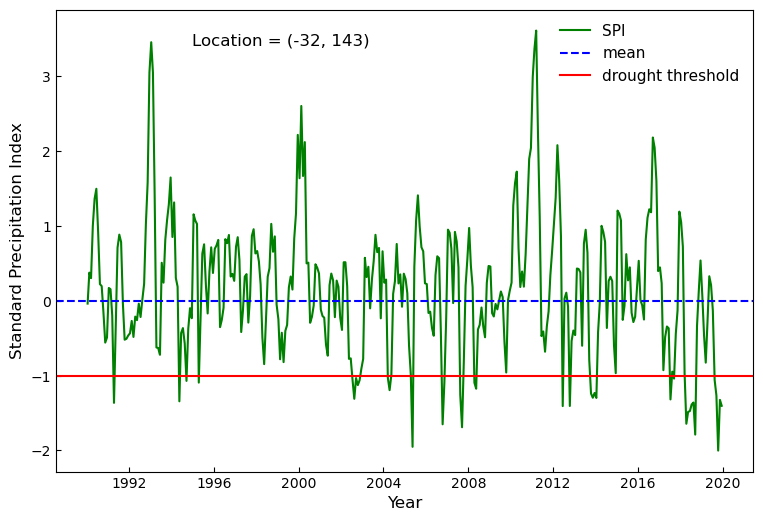

In [40]:
#example to show the mechanisms of the SPI function
time = precip_location['time'].values  
time_filtered = time[960:] #filtered to just last 30 years
spi_data_filtered = spi_data[960:] #filtered to just last 30 years for demonstration

draft = True
plt.figure(figsize=(9, 6))
ax = plt.gca()
plt.plot(time_filtered, spi_data_filtered, linestyle = '-', color='g', label='SPI')
ax.axhline(y=0, color='b', linestyle='--', label='mean')
ax.axhline(y=-1, color='r', linestyle='-', label='drought threshold')
plt.tick_params(axis='both', direction='in')
location_text = f"Location = ({spi_lat_val}, {spi_lon_val})"
ax.text(0.45, 0.95, location_text, transform=ax.transAxes, ha='right', va='top', fontsize=12)
# plt.title(f"Precipitation SPI Time Series at ({spi_lat_val}, {spi_lon_val})", fontsize=14)
plt.xlabel("Year", fontsize=12)  
plt.ylabel("Standard Precipitation Index", fontsize=12) 
plt.grid(False)
plt.legend(frameon=False, fontsize = 11)
if draft ==False:
    plt.savefig('/g/data/k10/as9583/DA4CS/plots/spi_sample.png', dpi = 300)


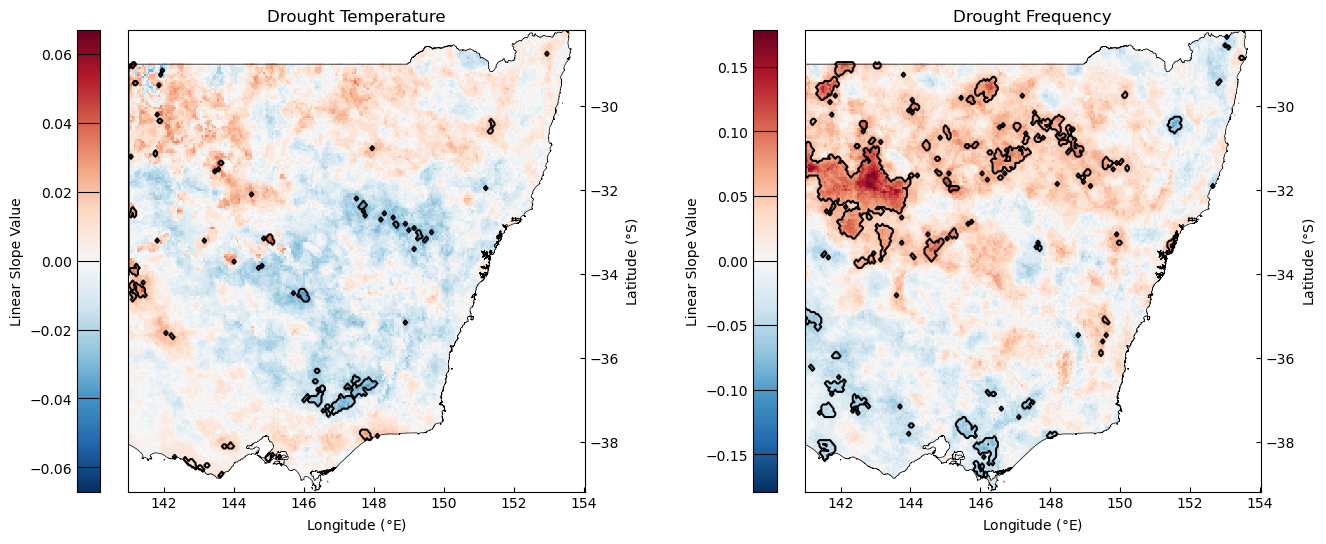

In [43]:
draft = True

fig, axes = plt.subplots(1, 2, figsize=(16, 6))   


# first plot (temperature linear trend)
ax1 = axes[0]
max_value = max(abs(temp_slope.min()), abs(temp_slope.max()))

vmin = -max_value
vmax = max_value
img = temp_slope.plot(ax=ax1, cmap="RdBu_r", add_colorbar=False, vmin=vmin, vmax=vmax)

cbar = plt.colorbar(img, ax=ax1, orientation="vertical", fraction = 0.05, pad=0.05, location="left")
cbar.ax.yaxis.set_label_position("left")
cbar.ax.yaxis.tick_left()
cbar.set_label("Linear Slope Value") 
cbar.ax.tick_params(axis='y', direction='in', length=16) 

ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()

lat, lon = np.meshgrid(temp_pvalue.lat, temp_pvalue.lon)
(temp_pvalue < 0.05).plot.contour(ax=ax1, levels=[0], colors=['black'])
ax1.set_xlabel("Longitude ($\\degree$E)")
ax1.set_ylabel("Latitude ($\\degree$S)")
ax1.tick_params(axis='both', direction='in')

fire.boundary.plot(ax=ax1, color="black", linewidth=0.5)
ax1.set_title("Drought Temperature")


# Second plot (frequency linear trend)
ax2 = axes[1]
max_value = max(abs(freq_slope.min()), abs(freq_slope.max()))

vmin = -max_value
vmax = max_value
img = freq_slope.plot(ax=ax2, cmap="RdBu_r", add_colorbar=False, vmin=vmin, vmax=vmax)

cbar = plt.colorbar(img, ax=ax2, orientation="vertical", fraction=0.05, pad=0.05, location="left")
cbar.ax.yaxis.set_label_position("left")
cbar.ax.yaxis.tick_left()
cbar.set_label("Linear Slope Value")
cbar.ax.tick_params(axis='y', direction='in', length=17)

ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
lat, lon = np.meshgrid(freq_pvalue.lat, freq_pvalue.lon)
(freq_pvalue < 0.05).plot.contour(ax=ax2, levels=[0], colors=['black'])

ax2.set_xlabel("Longitude ($\\degree$E)")
ax2.set_ylabel("Latitude ($\\degree$S)")
ax2.tick_params(axis='both', direction='in')

fire.boundary.plot(ax=ax2, color="black", linewidth=0.5)
ax2.set_title("Drought Frequency")


if draft == False:
    plt.savefig('/g/data/k10/as9583/DA4CS/plots/drought_temp_and_freq.png', dpi = 300)
    plt.savefig('/g/data/k10/as9583/DA4CS/plots/drought_temp_and_freq.pdf',dpi = 300)

